k=50


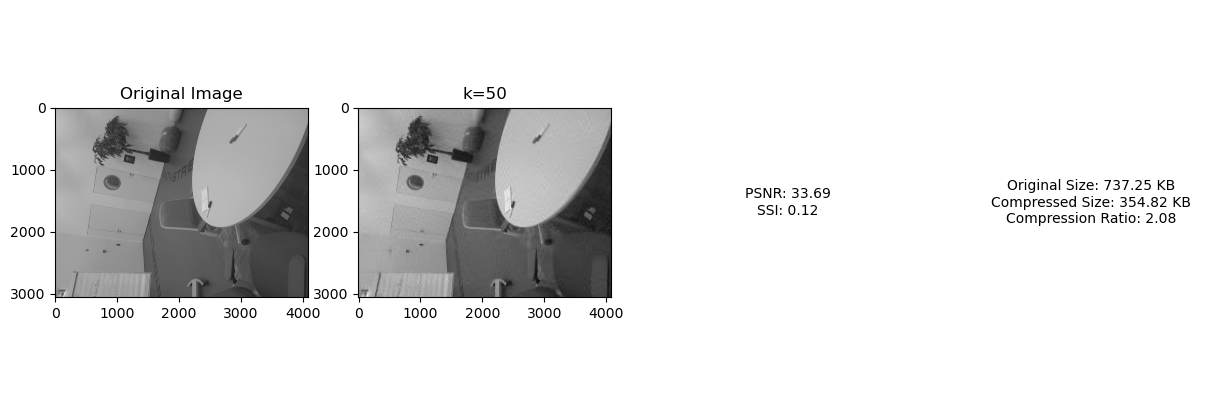

k=150


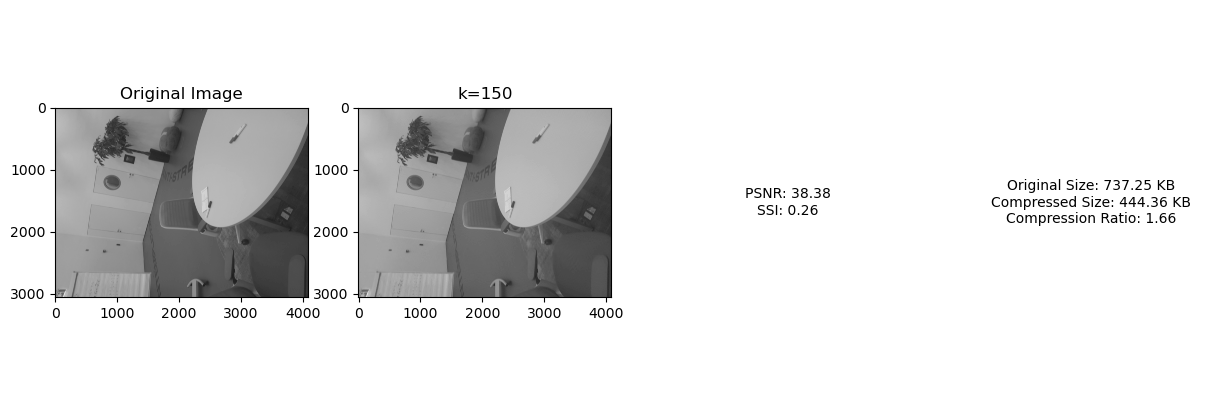

k=250


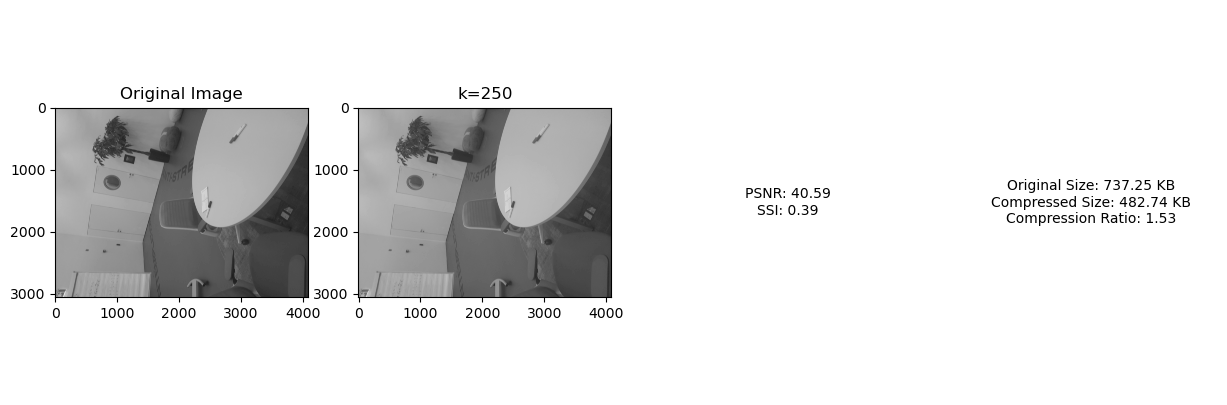

k=350


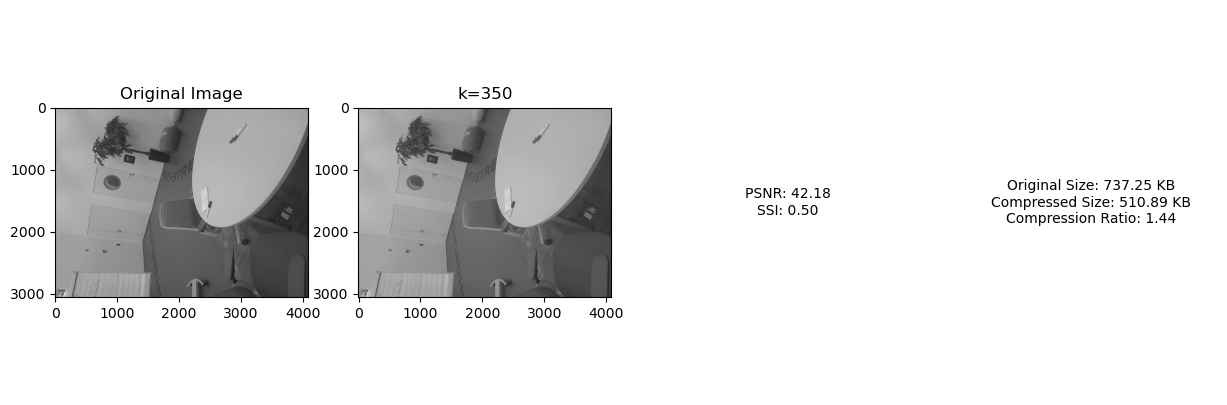

k=450


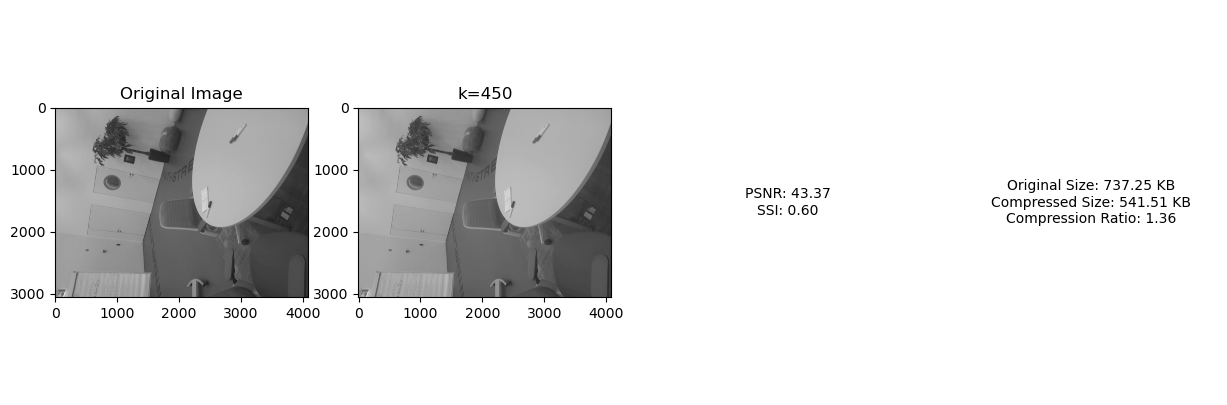

k=550


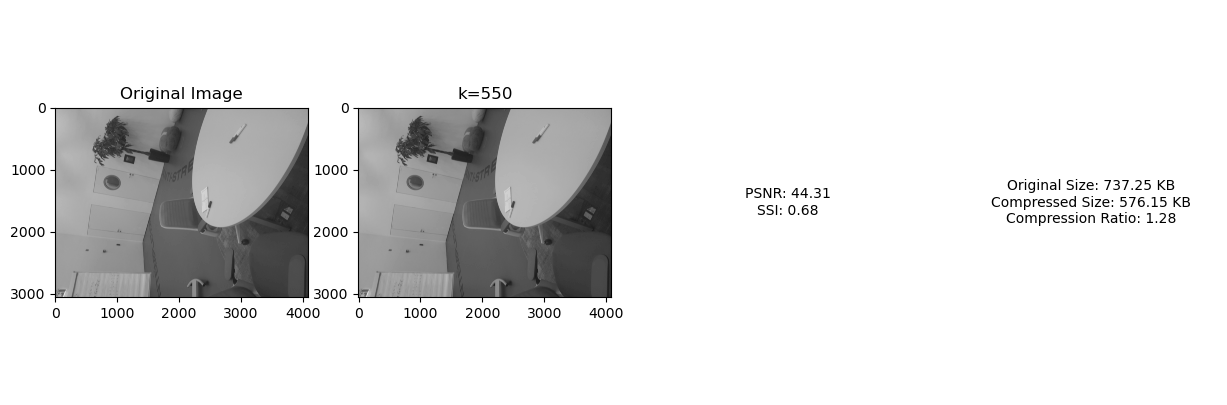

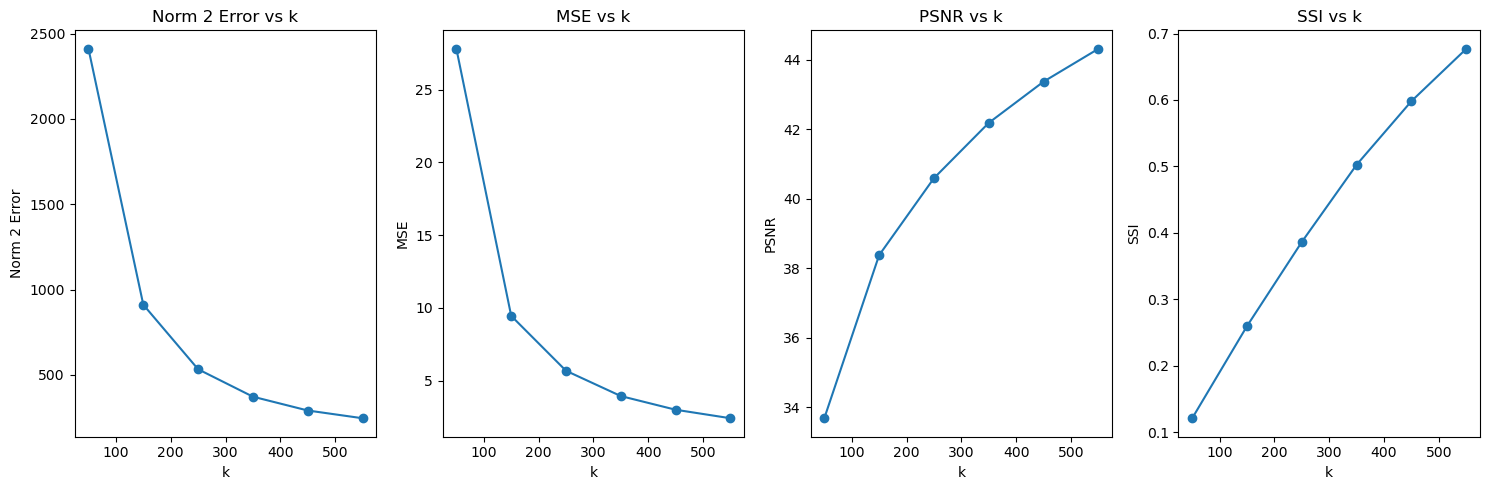

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from skimage.metrics import structural_similarity as ssim
def get_file_size(file_path):
    return os.path.getsize(file_path) / (1024)  # Convert to KB for readability
# Load image
A = np.array(Image.open('image1.jpg'))
# Convert to grayscale
Abw = np.mean(A, axis=2)
# Save black-white version of the picture
Image.fromarray(Abw.astype('uint8')).save('BW_original.jpg')
# Singular Value Decomposition (SVD)
U, S, Vt = np.linalg.svd(Abw, full_matrices=False)
# Initialize lists for metrics
MSE_error = []
PSNR_error = []
SSI_error = []
norm_2_error = []
compression_ratios = []
# Loop over different rank approximations
for k in range(50, 601, 100):  # rank of the approximation
    print(f"k={k}")

    # Reduced image using truncated SVD
    A1 = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]

    # Transform coefficients to the range of the pixels 0-255
    A1_comp = np.uint8(A1)

    # Norm 2 error (Eckhard-Young-Mirsky theorem)
    norm_2_error.append(S[k])

    # Calculate Mean Squared Error (MSE)
    D = np.abs(Abw - A1_comp)**2
    MSE_error.append(np.sum(D) / Abw.size)  # MSE = Σ((I - I_approx)^2) / (n * m)

    # Calculate Peak Signal-to-Noise Ratio (PSNR)
    PSNR_error.append(10 * np.log10(255**2 / MSE_error[-1]))  # PSNR = 10 * log10((255^2) / MSE)

    # Calculate Structural Similarity Index (SSI)
    ssi_index, _ = ssim(Abw, A1_comp, full=True)
    SSI_error.append(ssi_index)

    # Compression ratio calculation
    original_size = get_file_size('BW_original.jpg')
    compressed_image_path = f"compressed_image_r{k}.jpg"
    Image.fromarray(A1_comp).save(compressed_image_path)
    compressed_size = get_file_size(compressed_image_path)
    compression_ratios.append(original_size / compressed_size)

    # Display the original and reduced images with sizes
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(Abw, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(A1_comp, cmap='gray')
    plt.title(f'k={k}')

    plt.subplot(1, 4, 3)
    plt.text(0.5, 0.5, f'PSNR: {PSNR_error[-1]:.2f}\nSSI: {SSI_error[-1]:.2f}',
             fontsize=10, horizontalalignment='center', verticalalignment='center')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.text(0.5, 0.5, f'Original Size: {original_size:.2f} KB\nCompressed Size: {compressed_size:.2f} KB\nCompression Ratio: {compression_ratios[-1]:.2f}',
             fontsize=10, horizontalalignment='center', verticalalignment='center')
    plt.axis('off')

    plt.show()

# Plot the metrics graph
plt.figure(figsize=(15, 5))

# Plot Norm 2 Error vs k
plt.subplot(1, 4, 1)
plt.plot(range(50, 601, 100), norm_2_error, marker='o')
plt.title('Norm 2 Error vs k')
plt.xlabel('k')
plt.ylabel('Norm 2 Error')

# Plot MSE vs k
plt.subplot(1, 4, 2)
plt.plot(range(50, 601, 100), MSE_error, marker='o')
plt.title('MSE vs k')
plt.xlabel('k')
plt.ylabel('MSE')

# Plot PSNR vs k
plt.subplot(1, 4, 3)
plt.plot(range(50, 601, 100), PSNR_error, marker='o')
plt.title('PSNR vs k')
plt.xlabel('k')
plt.ylabel('PSNR')

# Plot SSI vs k
plt.subplot(1, 4, 4)
plt.plot(range(50, 601, 100), SSI_error, marker='o')
plt.title('SSI vs k')
plt.xlabel('k')
plt.ylabel('SSI')

plt.tight_layout()
plt.show()

In [2]:
#compare  exact svd and  randomized svd

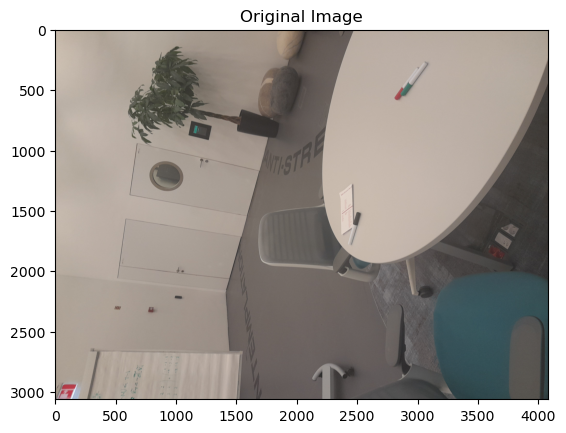

Time for Randomized SVD: 0.2159292999999991
Time for Exact SVD: 31.650705799999997
Error from randomized SVD: 19650.5529965874
Error from exact SVD: 13251.865158309938
Compression Ratio for Randomized SVD: 16.650729189589292
Compression Ratio for Exact SVD: 17.48326564906876


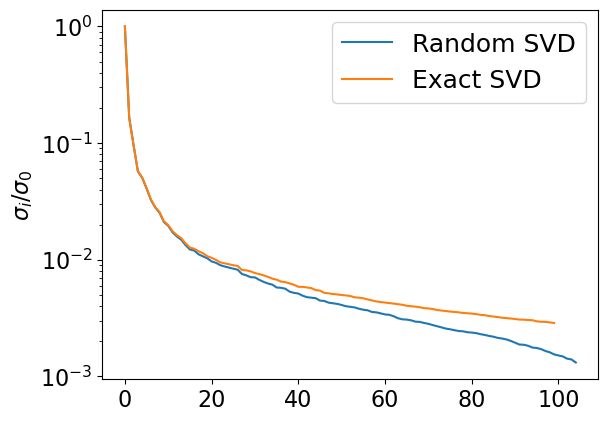

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import timeit
def load_and_show_image(image_path):
    # Load and display the original image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title("Original Image")
    plt.show()
    return np.array(img).mean(axis=-1)  # Convert to grayscale (2D array)

def randomized_svd(A, rank, p):
    m, n = A.shape
    G = np.random.randn(n, rank + p)
    Y = A @ G
    Q, _ = np.linalg.qr(Y)
    B = Q.T @ A
    u, S, V = np.linalg.svd(B, full_matrices=False)
    U = Q @ u
    return U, S, V

def exact_svd(A, rank):
    u, s, v = np.linalg.svd(A)
    return u[:, :rank], s[:rank], v[:rank, :]

def plot_singular_values(S, label):
    plt.semilogy(S / S[0], label=label)

# Load the JPEG image
image_path = 'image1.jpg' 
image_matrix = load_and_show_image(image_path)

# Define the rank for compression
rank = 100

# Measure time for randomized SVD
time_rand = timeit.timeit(lambda: randomized_svd(image_matrix, rank, 5), number=1)

# Measure time for exact SVD
time_exact = timeit.timeit(lambda: exact_svd(image_matrix, rank), number=1)

print("Time for Randomized SVD:", time_rand)
print("Time for Exact SVD:", time_exact)

# Perform randomized SVD
U_rand, S_rand, V_rand = randomized_svd(image_matrix, rank, 5)

# Perform exact SVD
U_exact, S_exact, V_exact = exact_svd(image_matrix, rank)

# Display the result and compare with exact SVD
print("Error from randomized SVD:", np.linalg.norm(image_matrix - U_rand @ np.diag(S_rand) @ V_rand))
print("Error from exact SVD:", np.linalg.norm(image_matrix - U_exact @ np.diag(S_exact) @ V_exact))

# Calculate the original and compressed data sizes
original_data_size = image_matrix.size
compressed_data_size_rand = (U_rand.size + S_rand.size + V_rand.size)
compressed_data_size_exact = (U_exact.size + S_exact.size + V_exact.size)

# Calculate compression ratios
compression_ratio_rand = original_data_size / compressed_data_size_rand
compression_ratio_exact = original_data_size / compressed_data_size_exact

# Print compression ratios
print("Compression Ratio for Randomized SVD:", compression_ratio_rand)
print("Compression Ratio for Exact SVD:", compression_ratio_exact)

# Plot singular values
plot_singular_values(S_rand, "Random SVD")
plot_singular_values(S_exact, "Exact SVD")

# Customize the plot
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\sigma_i / \sigma_0$", fontsize=16)
plt.show()

In [4]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


PSNR for Randomized SVD: 32.7005451980719
MSE for Randomized SVD: 30.929148490299383

PSNR for Exact SVD: 36.12250056682262
MSE for Exact SVD: 14.06605874135179


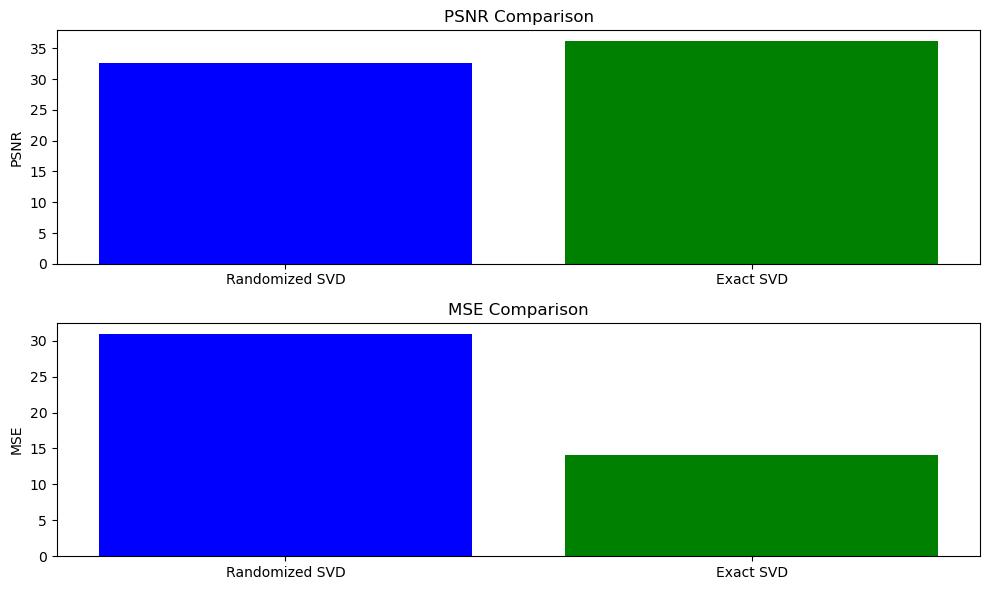

In [5]:
# Calculate PSNR and MSE for Randomized SVD
psnr_rand = peak_signal_noise_ratio(image_matrix, U_rand @ np.diag(S_rand) @ V_rand, data_range=image_matrix.max() - image_matrix.min())
mse_rand = mean_squared_error(image_matrix, U_rand @ np.diag(S_rand) @ V_rand)

# Calculate PSNR and MSE for Exact SVD
psnr_exact = peak_signal_noise_ratio(image_matrix, U_exact @ np.diag(S_exact) @ V_exact, data_range=image_matrix.max() - image_matrix.min())
mse_exact = mean_squared_error(image_matrix, U_exact @ np.diag(S_exact) @ V_exact)

# Print PSNR and MSE
print("PSNR for Randomized SVD:", psnr_rand)
print("MSE for Randomized SVD:", mse_rand)
print("\nPSNR for Exact SVD:", psnr_exact)
print("MSE for Exact SVD:", mse_exact)

# Plotting PSNR
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.bar(['Randomized SVD', 'Exact SVD'], [psnr_rand, psnr_exact], color=['blue', 'green'])
plt.title('PSNR Comparison')
plt.ylabel('PSNR')

# Plotting MSE
plt.subplot(2, 1, 2)
plt.bar(['Randomized SVD', 'Exact SVD'], [mse_rand, mse_exact], color=['blue', 'green'])
plt.title('MSE Comparison')
plt.ylabel('MSE')

# Customize the plot
plt.tight_layout()
plt.show()

the mathematical equations for each metric:

1. Mean Squared Error (MSE):
   Mean Squared Error measures the average squared difference between the original image \( I(i, j) \) and the approximated image $( I_{\text{approx}}(i, j) )$ across all pixels.

   $[ MSE = \frac{1}{mn} \sum_{i=1}^{m} \sum_{j=1}^{n} (I(i, j) - I_{\text{approx}}(i, j))^2 ]$

   Where:
   - ( m ) is the number of rows in the image.
   - ( n ) is the number of columns in the image.

2. Peak Signal-to-Noise Ratio (PSNR):
   PSNR is a measure of how well the approximated image preserves the quality of the original image. It is often expressed in decibels (dB).

   $[ PSNR = 10 \cdot \log_{10}\left(\frac{{\text{max}^2}}{{MSE}}\right) ]$

   Where:
   - $(\text{max})$ is the maximum possible pixel intensity (e.g., 255 for an 8-bit image).

3. Norm 2 Error:
   The Norm 2 Error represents the singular value corresponding to the (k+1)-th singular vector obtained from the Singular Value Decomposition (SVD).

   $[ \text{Norm 2 Error} = \sigma_{k+1} ]$

   Where:
   - $(\sigma_{k+1})$ is the (k+1)-th singular value.

4. Compression Ratio:
   Compression Ratio quantifies the degree of compression achieved by comparing the size of the original image to the size of the compressed image.

   $[ \text{Compression Ratio} = \frac{\text{Original Size}}{\text{Compressed Size}} ]$

   Where:
   - $(\text{Original Size})$ is the size of the original image.
   - $(\text{Compressed Size})$ is the size of the compressed image.

These metrics provide quantitative measures to evaluate the quality of the image approximation and the effectiveness of the compression achieved by the SVD-based approach.